# Neural Network

We will discuss how to build a feedforward neural network model from scratch.

# Required Libraries

In [1]:
import numpy as np

## Activation Functions And Their Derivatives
Here we are going to define different activation function together with their  derivatives.

In [2]:
# Activation Functions and Derivatives
def step(z): 
    return np.where(z >= 0, 1, 0)
def d_step(z): 
    return np.zeros_like(z)

def linear(z): 
    return z
def d_linear(z): 
    return np.ones_like(z)

def sigmoid(z): 
    z = np.clip(z, -500, 500)
    return 1 / (1 + np.exp(-z))
def d_sigmoid(z): 
    return sigmoid(z) * (1 - sigmoid(z))

def tanh(z): 
    return np.tanh(z)
def d_tanh(z): 
    return 1 - np.tanh(z) ** 2

def relu(z): 
    return np.maximum(0, z)
def d_relu(z): 
    return np.where(z > 0, 1, 0)

def leaky_relu(z,alpha=0.01): 
    return np.where(z > 0, z, alpha * z)
def d_leaky_relu(z,alpha=0.01): 
    return np.where(z > 0, 1, alpha)

def elu(z,alpha=0.01): 
    return np.where(z >= 0, z, alpha * (np.exp(z) - 1))
def d_elu(z,alpha=0.01): 
    return np.where(z >= 0, 1, alpha * np.exp(z))

def selu(z,selu_lambda,selu_alpha): 
    return selu_lambda * np.where(z >= 0, z, selu_alpha * (np.exp(z) - 1))
def d_selu(z,selu_lambda,selu_alpha): 
    return selu_lambda * np.where(z >= 0, 1, selu_alpha * np.exp(z))

def gelu(z): 
    return 0.5 * z * (1 + np.tanh(np.sqrt(2 / np.pi) * (z + 0.044715 * z**3)))
def d_gelu(z):
    tanh_term = np.tanh(np.sqrt(2 / np.pi) * (z + 0.044715 * z**3))
    left = 0.5 * (1 + tanh_term)
    sech2 = 1 - tanh_term**2
    right = 0.5 * z * sech2 * (np.sqrt(2 / np.pi) * (1 + 3 * 0.044715 * z**2))
    return left + right

def swish(z):
    return z / (1 + np.exp(-z))
def d_swish(z):
    sig = sigmoid(z)
    return sig + z * sig * (1 - sig)

def softmax(z):
    exp_z = np.exp(z - np.max(z, axis=0, keepdims=True))
    return exp_z / np.sum(exp_z, axis=0, keepdims=True)
def d_softmax(z):
    # Derivative of softmax combined with cross-entropy is simplified in backprop
    # Usually handled in loss derivative, so just return 1 for chain rule
    return np.ones_like(z)

# Get The Sellected Activation
def get_activation(name):
    if name in ["linear", None]:
        return linear, d_linear
    elif name == "step":
        return step, d_step
    elif name == "sigmoid":
        return sigmoid, d_sigmoid
    elif name == "relu":
        return relu, d_relu
    elif name == "leaky_relu":
        return leaky_relu, d_leaky_relu
    elif name == "softmax":
        return softmax, d_softmax
    elif name == "tanh":
        return tanh, d_tanh
    elif name == "elu":
        return elu, d_elu
    elif name == "selu":
        return selu, d_selu
    elif name == "gelu":
        return gelu, d_gelu
    elif name == "swish":
        return swish, d_swish
    else:
        raise ValueError(f"Unknown activation function: {name}")

## Loss Functions And Their Derivatives
Here we are going to define different activation function together with their  derivatives.

In [3]:
# -----------------------------
# Binary Cross-Entropy (BCE)
# -----------------------------

def bce(y, y_pred):
    """
    Binary Cross-Entropy Loss
    y: true labels (0 or 1), shape (1, m)
    y_pred: predicted probabilities, shape (1, m)
    """
    y = y.reshape(1,-1)
    y_pred = np.clip(y_pred, 1e-9, 1 - 1e-9)  # avoid log(0)
    return -np.mean(y * np.log(y_pred) + (1 - y) * np.log(1 - y_pred))

def d_bce(y, y_pred):
    """
    Derivative of Binary Cross-Entropy Loss
    """
    y = y.reshape(1,-1)
    m = y.shape[1]
    y_pred = np.clip(y_pred, 1e-9, 1 - 1e-9)
    return (y_pred - y) / (y_pred * (1 - y_pred)) / m


# -----------------------------
# Categorical Cross-Entropy (Multi-class)
# -----------------------------

def cross_entropy(y, y_pred):
    """
    Categorical Cross-Entropy Loss (with one-hot conversion)
    y: integer class labels, shape (1, m)
    y_pred: predicted softmax probabilities, shape (num_classes, m)
    """
    y = y.reshape(1,-1)
    m = y.shape[1]
    num_classes = y_pred.shape[0]

    # Convert integer labels to one-hot encoding
    y_one_hot = np.eye(num_classes)[y.astype(int).flatten()].T
    y_pred = np.clip(y_pred, 1e-9, 1 - 1e-9)

    log_likelihood = -np.log(y_pred) * y_one_hot
    loss = np.sum(log_likelihood) / m
    return loss

def d_cross_entropy(y, y_pred):
    """
    Derivative of Categorical Cross-Entropy (Softmax + CE combined)
    Simplified gradient when using softmax in the last layer
    """
    y = y.reshape(1,-1)
    m = y.shape[1]
    num_classes = y_pred.shape[0]

    # Convert integer labels to one-hot encoding
    y_one_hot = np.eye(num_classes)[y.astype(int).flatten()].T

    return (y_pred - y_one_hot) / m


# -----------------------------
# Mean Squared Error (MSE)
# -----------------------------

def mse(y, y_pred):
    """
    Mean Squared Error Loss
    y: true values, shape (output_dim, m)
    y_pred: predicted values, shape (output_dim, m)
    """
    y = y.reshape(1,-1)
    return np.mean((y - y_pred) ** 2)

def d_mse(y, y_pred):
    """
    Derivative of Mean Squared Error
    """
    y = y.reshape(1,-1)
    m = y.shape[1]
    return 2 * (y_pred - y) / m


# -----------------------------
# Mean Absolute Error (MAE / L1 Loss)
# -----------------------------
def mae(y, y_pred):
    y = y.reshape(1,-1)
    return np.mean(np.abs(y - y_pred))

def d_mae(y, y_pred):
    y = y.reshape(1,-1)
    m = y.shape[1]
    return np.sign(y_pred - y) / m


## Initialization
Here we initilaize our weights and bias

In [4]:
def initialize(architecture):
    layers_neuron = [layer[0] for layer in architecture]
    layers_activation = [layer[1] for layer in architecture]

    L = len(layers_neuron) - 1
    d = {"L":L,"A0": None}
    for i in range(1, L + 1):
        if layers_activation[i] == "relu":
            d[f"W{i}"] = np.random.randn(layers_neuron[i], layers_neuron[i - 1]) * np.sqrt(2 / layers_neuron[i - 1])
        else:
            d[f"W{i}"] = np.random.randn(layers_neuron[i], layers_neuron[i - 1]) * np.sqrt(1 / layers_neuron[i - 1])
        #d[f"W{i}"] = np.random.randn(layers_neuron[i], layers_neuron[i - 1]) * 0.01
        d[f"b{i}"] = np.zeros((layers_neuron[i], 1))
        d[f"activation{i}"] = layers_activation[i]
    return L,d

## Feedforward
Here we will impliment feedforward

In [5]:
def feedforward(X,d,L):
    d["A0"] = X
    for i in range(1, L + 1):
        d[f"Z{i}"] = d[f"W{i}"] @ d[f"A{i - 1}"] + d[f"b{i}"]
        act_fn, _ = get_activation(d[f"activation{i}"])
        d[f"A{i}"] = act_fn(d[f"Z{i}"])
    return d,d[f"A{L}"]

## Accuracy
Here we are going to compute the accuracy

In [6]:
def accuracy(y_true, y_pred):
    y_true = y_true.reshape(1,-1)
    if y_pred.shape[0] == 1:
        # Binary classification or regression
        if set(np.unique(y_true)) <= {0, 1}:
            preds = (y_pred > 0.5).astype(int)
            return np.mean(preds.flatten() == y_true.flatten())
        else:
            # Regression accuracy: use R^2 score
            ss_res = np.sum((y_true - y_pred)**2)
            ss_tot = np.sum((y_true - np.mean(y_true))**2)
            return 1 - ss_res / ss_tot
    else:
        # Multi-class classification
        y_pred_classes = np.argmax(y_pred, axis=0)
        y_true_classes = y_true.flatten()
        return np.mean(y_pred_classes == y_true_classes)


## Backpropagation
Here we will impliment Backpropagation

In [7]:
def backprop(criterion,d,Y,L):
    # Backward pass
    if criterion == "bce":
        loss = bce(Y, d[f"A{L}"])
        d[f"dL/dA{L}"] = d_bce(Y, d[f"A{L}"])
    elif criterion == "ce":
        loss = cross_entropy(Y, d[f"A{L}"])
        d[f"dL/dA{L}"] = d_cross_entropy(Y, d[f"A{L}"])
    elif criterion == "mse":
        loss = mse(Y, d[f"A{L}"])
        d[f"dL/dA{L}"] = d_mse(Y, d[f"A{L}"])
    elif criterion == "mae":
        loss = mae(Y, d[f"A{L}"])
        d[f"dL/dA{L}"] = d_mae(Y, d[f"A{L}"])
    else:
        raise ValueError("Unknown loss criterion")
    
    accu = accuracy(Y,d[f"A{L}"])


    for i in reversed(range(1, L + 1)):
        _, d_act = get_activation(d[f"activation{i}"])
        # For softmax + cross-entropy, derivative of softmax handled in loss grad
        if d[f"activation{i}"] == "softmax":
            d[f"dL/dZ{i}"] = d[f"dL/dA{i}"]  # already combined derivative
        else:
            d[f"dL/dZ{i}"] = d[f"dL/dA{i}"] * d_act(d[f"Z{i}"])
        d[f"dL/dW{i}"] = d[f"dL/dZ{i}"] @ d[f"A{i - 1}"].T
        d[f"dL/db{i}"] = np.sum(d[f"dL/dZ{i}"], axis=1, keepdims=True)
        if i > 1:
            d[f"dL/dA{i - 1}"] = d[f"W{i}"].T @ d[f"dL/dZ{i}"]
    return d,loss,accu

## Make Prediction

In [8]:
def predict(X,d):
    A = X.T
    L = d[f"L"]
    for i in range(1, L + 1):
        Z = d[f"W{i}"] @ A + d[f"b{i}"]
        act_fn, _ = get_activation(d[f"activation{i}"])
        A = act_fn(Z)
    return A

## Stochastic Gradient Descent (SGD)
Here we are going to implement SGD

In [9]:
def optimizer(X, Y, architecture, criterion, lr=0.01, epochs=10, batch_size=32, tol=0.001, val_split=0.3):
    
    n, d = X.shape

    # Split train/val inside optimizer
    train_size = int(n * (1 - val_split))
    idx = np.random.permutation(n)
    train_idx, val_idx = idx[:train_size], idx[train_size:]

    x_train, x_val = X[train_idx].T, X[val_idx].T
    y_train, y_val = Y[train_idx].reshape(1, -1), Y[val_idx].reshape(1, -1)

    L, net = initialize(architecture)

    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []


    for epoch in range(epochs):
        running_loss = 0.0
        running_accu = 0.0
        n_train = x_train.shape[1]

        # Shuffle training data each epoch
        indices = np.random.permutation(n_train)
        shuffled_x = x_train[:, indices]
        shuffled_y = y_train[:, indices]


        # Mini-batch loop
        for start in range(0, n_train, batch_size):
            end = start + batch_size
            batch_x = shuffled_x[:, start:end]
            batch_y = shuffled_y[:, start:end]

            net, y_pred = feedforward(batch_x, net, L)
            net, loss, accu = backprop(criterion, net, batch_y, L)

            running_loss += loss * batch_x.shape[1] 
            running_accu += accu * batch_x.shape[1]

            # Gradient descent step
            for i in range(1, L + 1):
                net[f"W{i}"] -= lr * net[f"dL/dW{i}"]
                net[f"b{i}"] -= lr * net[f"dL/db{i}"]

        avg_train_loss = running_loss / n_train
        avg_train_accu = running_accu / n_train

        train_losses.append(avg_train_loss)
        train_accuracies.append(avg_train_accu)


        # Validation evaluation (no backprop, no updates)
        y_val_pred = predict(x_val.T,net)

        # Compute val loss and accuracy
        if criterion == "bce":
            val_loss = bce(y_val, y_val_pred)
        elif criterion == "ce":
            val_loss = cross_entropy(y_val, y_val_pred)
        elif criterion == "mse":
            val_loss = mse(y_val, y_val_pred)
        elif criterion == "mae":
            val_loss = mae(y_val, y_val_pred)
        else:
            raise ValueError("Unknown loss criterion")

        val_accu = accuracy(y_val, y_val_pred)

        val_losses.append(val_loss)
        val_accuracies.append(val_accu)

        # Optional: print progress
        #print(f"Epoch {epoch+1}: Train Loss={avg_train_loss:.4f}, Train Acc={avg_train_accu:.4f}, Val Loss={val_loss:.4f}, Val Acc={val_accu:.4f}")


    return net, train_losses, train_accuracies, val_losses, val_accuracies


# Testing 
Herew we are going to load different dataset to test our neural network.

In [10]:
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer,load_digits,fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd

In [11]:
def plot_loss_accuracy(train_losses,val_losses,train_accuracies,val_accuracies,loss_type=""):
    plt.figure(figsize=(14, 5))

    plt.subplot(1, 2, 1)
    plt.plot(range(1, len(train_losses)+1), train_losses, label='Train Loss', color='red')
    plt.plot(range(1, len(val_losses)+1), val_losses, label='Validation Loss', color='orange')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(f"{loss_type} Loss")
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(range(1, len(train_accuracies)+1), train_accuracies, label='Train Accuracy', color='blue')
    plt.plot(range(1, len(val_accuracies)+1), val_accuracies, label='Validation Accuracy', color='green')
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Training and Validation Accuracy")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

## Task 1: Binary Classification
Here we impliment binary classification using the breast cancer dataset from sklearn.

Test Accuracy: 0.9825
Binary Cross Entropy Loss: 0.0674


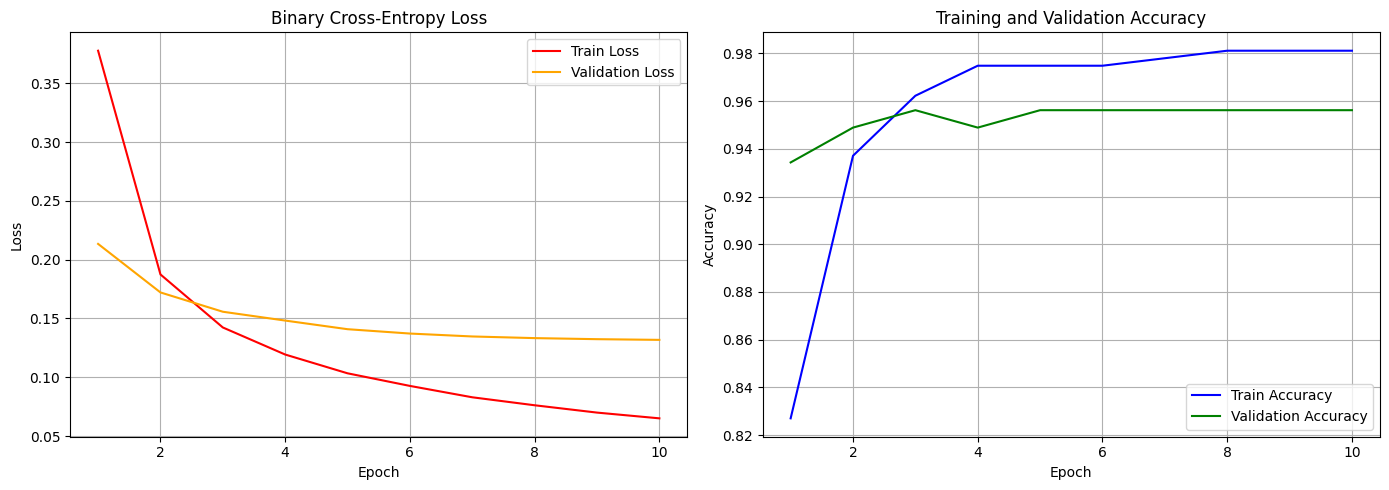

In [12]:
data = load_breast_cancer()

X = data.data
y = data.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train)

n,d = X_scaled.shape
num_classes = len(np.unique(y_train)) 
# Architecture
architecture = [
    (d, None),                  # Input layer
    (64, "relu"),               # Hidden layer
    (1, "sigmoid")              # Output layer
]
criterion = "bce"

dict, train_losses, train_accuracies, val_losses, val_accuracies = optimizer(
    X_scaled, y_train, architecture, criterion="bce", lr=0.1, epochs=10, batch_size=32, val_split=0.3
)

# Evaluate On Test Data
X_test_scaled = scaler.transform(X_test)
y_pred_test = predict(X_test_scaled, dict)

print(f"Test Accuracy: {accuracy(y_test, y_pred_test):.4f}")
print(f"Binary Cross Entropy Loss: {bce(y_test, y_pred_test):.4f}")

plot_loss_accuracy(train_losses,val_losses,train_accuracies,val_accuracies,loss_type="Binary Cross-Entropy")

## Task 2: Multi Class Classification
Here we impliment multi-class classification using the mnist dataset from sklearn.

Test Accuracy: 0.9694
Cross Entropy Loss: 0.1142


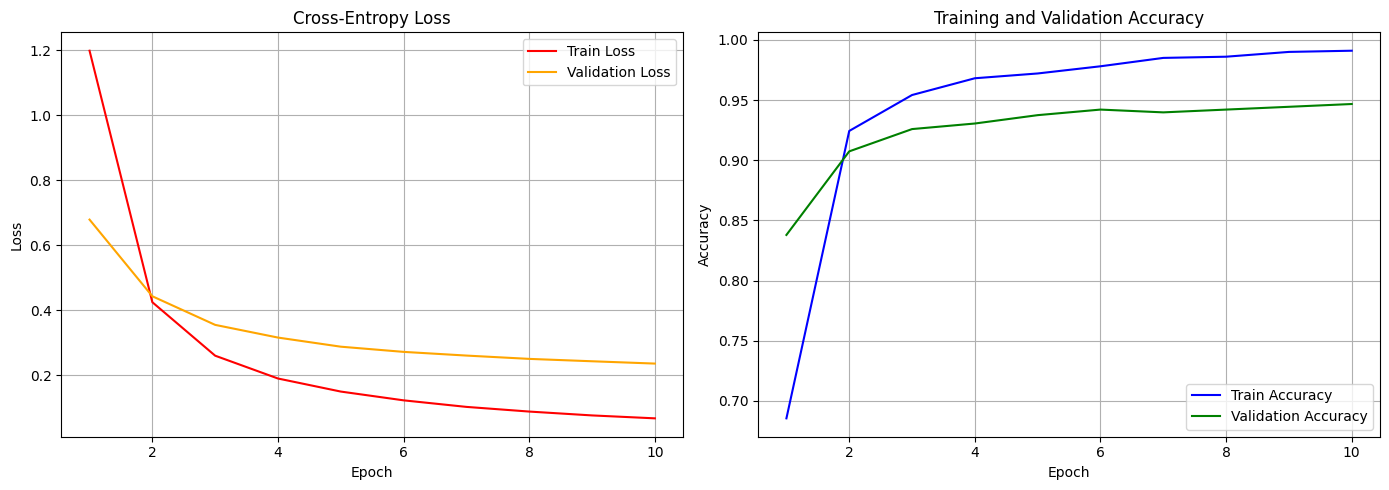

In [13]:
data = load_digits()

X = data.data
y = data.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train)

n,d = X_scaled.shape
num_classes = len(np.unique(y_train)) 
# Architecture
architecture = [
    (d, None),                  # Input layer
    (64, "relu"),               # Hidden layer
    (num_classes, "softmax")              # Output layer
]
criterion = "ce"

dict, train_losses, train_accuracies, val_losses, val_accuracies = optimizer(
    X_scaled, y_train, architecture, criterion="ce", lr=0.1, epochs=10, batch_size=32, val_split=0.3
)

# Evaluate On Test Data
X_test_scaled = scaler.transform(X_test)
y_pred_test = predict(X_test_scaled, dict)

print(f"Test Accuracy: {accuracy(y_test, y_pred_test):.4f}")
print(f"Cross Entropy Loss: {cross_entropy(y_test, y_pred_test):.4f}")

plot_loss_accuracy(train_losses,val_losses,train_accuracies,val_accuracies,loss_type="Cross-Entropy")

## Task 3: Regression Example

Here we implement regression using the california Housing dataset from `sklearn`.

Test Accuracy (R²): 0.7578198791907678
Test MSE: 0.3173550046598837


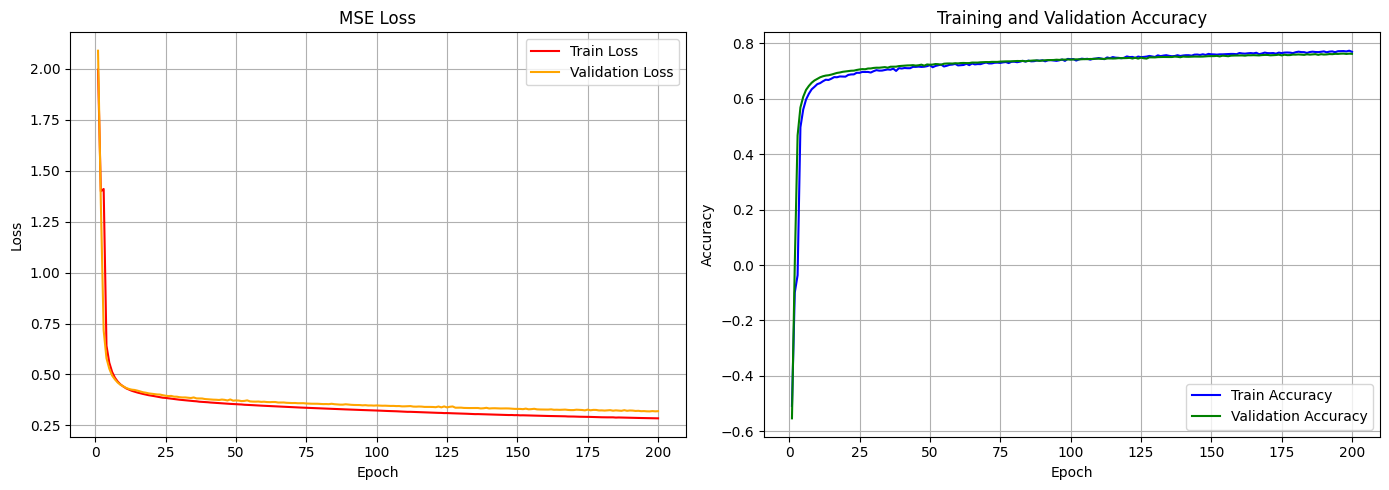

In [14]:
data = fetch_california_housing()

X = data.data
y = data.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train)

n,d = X_scaled.shape
# Architecture
architecture = [
    (X.shape[1], None),  # Input
    (128, "leaky_relu"),
    (64, "relu"),
    (1, "linear")        # Output for regression
]
criterion = "mse"

dict, train_losses, train_accuracies, val_losses, val_accuracies = optimizer(
    X_scaled, y_train, architecture, criterion="mse", lr=0.001, epochs=200, batch_size=32, val_split=0.3
)


# Evaluate On Test Data
X_test_scaled = scaler.transform(X_test)
y_pred_test = predict(X_test_scaled, dict)

print(f"Test Accuracy (R²): {accuracy(y_test, y_pred_test)}")
print(f"Test MSE: {mse(y_test, y_pred_test)}")

plot_loss_accuracy(train_losses,val_losses,train_accuracies,val_accuracies,loss_type="MSE")



## Neural Network Class
Here we have combined all that we have discussed above in to a class. You can see the usage below



-------------------- Model Summary ---------------------
Layer    Type      Output Shape        Params    Activation
------------------------------------------------------------
0        Input     (64,)               0         None
1        Dense     (64,)               4160      relu
2        Dense     (10,)               650       softmax
------------------------------------------------------------
Total parameters: 4810
------------------------------------------------------------

Epoch [ 1/20] | Train Loss: 1.6720, Train Acc: 0.4886 | Val Loss: 0.9581, Val Acc: 0.7708
Epoch [ 3/20] | Train Loss: 0.4364, Train Acc: 0.9134 | Val Loss: 0.4008, Val Acc: 0.9190
Epoch [ 5/20] | Train Loss: 0.2500, Train Acc: 0.9572 | Val Loss: 0.2756, Val Acc: 0.9421
Epoch [ 7/20] | Train Loss: 0.1778, Train Acc: 0.9672 | Val Loss: 0.2227, Val Acc: 0.9468
Epoch [ 9/20] | Train Loss: 0.1386, Train Acc: 0.9711 | Val Loss: 0.1902, Val Acc: 0.9583
Epoch [11/20] | Train Loss: 0.1129, Train Acc: 0.9791 | Val 

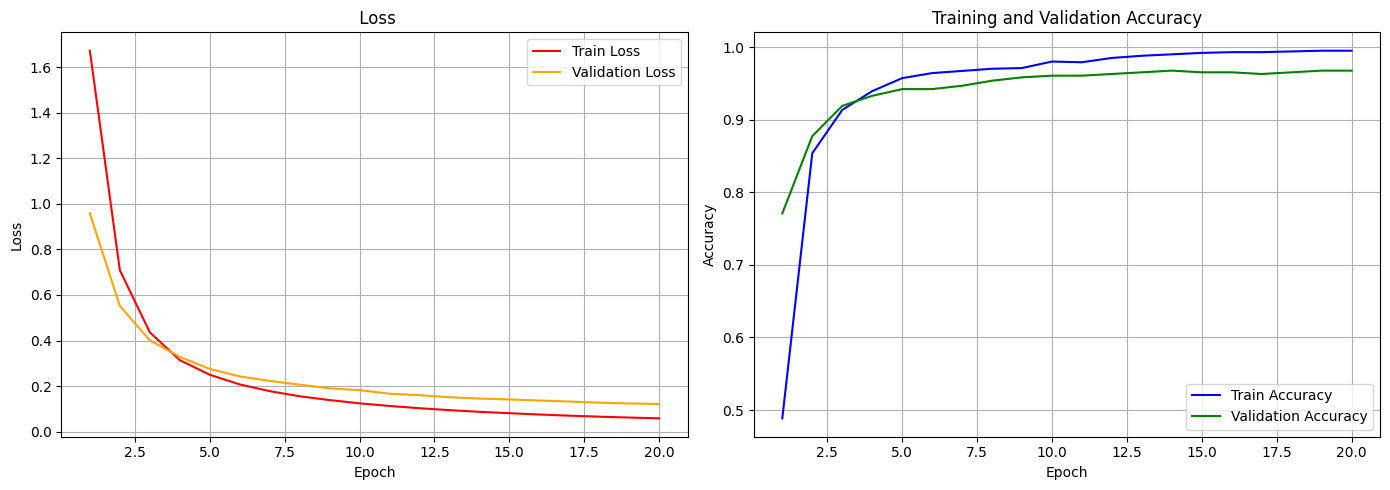

In [15]:
import sys
import os
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

from ek_ml_package.neural_network import Layer,NeuralNetwork

data = load_digits()

X = data.data
y = data.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train)

n,d = X_scaled.shape
num_classes = len(np.unique(y_train)) 

# Architecture
architecture = [
    Layer(X.shape[1]),                   # Input
    Layer(64, "relu"),                   # Hidden layer
    Layer(num_classes, "softmax")        # Output layer
]
model = NeuralNetwork(architecture, criterion="ce", learning_rate=0.06)
model.summary()
history = model.train(X_scaled, y_train,epochs=20, batch_size=32,val_split=0.3)

# Evaluate On Test Data
X_test_scaled = scaler.transform(X_test)
y_pred_test = model.predict(X_test_scaled)

acc, loss = model.score(X_test_scaled, y_test, return_loss=True)

print(f"Test Accuracy: {acc:.4f}")
print(f"Cross Entropy Loss: {loss:.4f}")

plot_loss_accuracy(history["train_loss"],history[ "val_loss"],history["train_acc"],history["val_acc"],loss_type="")
